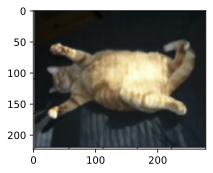

In [1]:
# -*- coding: utf-8 -*-
# @Time    : 2023/12/3 下午4:43
# @Author  : nanji
# @Site    : 
# @File    : 36_p2.py
# @Software: PyCharm 
# @Comment :
import torch
import torchvision
from torch import nn
from d2l import torch as d2l

d2l.set_figsize()
img = d2l.Image.open('../data/cat1.png')
d2l.plt.imshow(img)


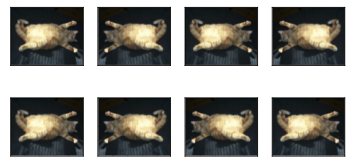

In [2]:

def apply(img, aug, num_rows=2, num_cols=4, scale=1.5):
    Y = [aug(img) for _ in range(num_rows * num_cols)]
    d2l.show_images(Y, num_rows, num_cols, scale=scale)


apply(img, torchvision.transforms.RandomHorizontalFlip())


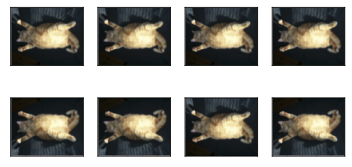

In [3]:
apply(img, torchvision.transforms.RandomVerticalFlip())


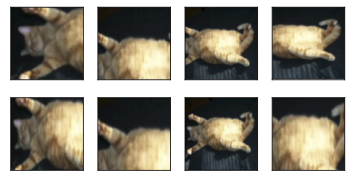

In [4]:
shape_aug = torchvision.transforms.RandomResizedCrop(
    (200, 200), scale=(0.1, 1), ratio=(0.5, 2)
)
apply(img, shape_aug)

2222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222


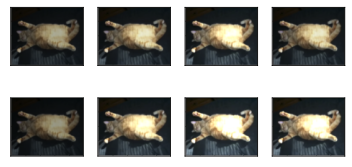

In [5]:
print('2' * 100)
apply(img, torchvision.transforms.ColorJitter(
    brightness=0.5, contrast=0, saturation=0, hue=0
))



3333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333333


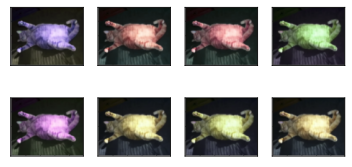

In [6]:
print('3'*100)

apply(img,torchvision.transforms.ColorJitter(
    brightness=0,contrast=0,saturation=0,hue=0.5
))

4444444444444444444444444444444444444444444444444444444444444444444444444444444444444444444444444444


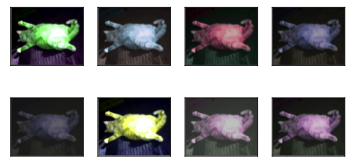

In [7]:
print('4'*100)
color_aug=torchvision.transforms.ColorJitter(
    brightness=0.5,contrast=0.5,saturation=0.5,\
    hue=0.5
)
apply(img,color_aug)

5555555555555555555555555555555555555555555555555555555555555555555555555555555555555555555555555555


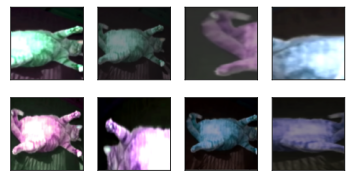

In [8]:
print('5' * 100)
augs = torchvision.transforms.Compose([
    torchvision.transforms.RandomHorizontalFlip(),
    color_aug, shape_aug
])
apply(img,augs)


Files already downloaded and verified


array([<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>],
      dtype=object)

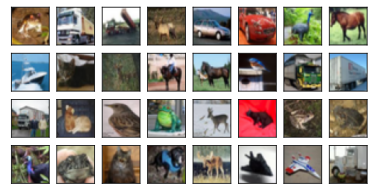

In [9]:
all_images = torchvision.datasets.CIFAR10(
    train=True, root='../data', download=True
)
d2l.show_images([all_images[i][0] for i in range(32)], 4, 8, scale=0.8)


In [10]:

# 使用最简单的随机左右翻转
train_augs = torchvision.transforms.Compose([
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.ToTensor()
])
test_augs = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor()
])


def load_cifar10(is_train, augs, batch_size):
    dataset = torchvision.datasets.CIFAR10(
        root='../data', train=is_train,
        transform=augs, download=True
    )
    dataloader = torch.utils.data.DataLoader(
        dataset, batch_size=batch_size, shuffle=is_train,
        # num_workers=d2l.get_dataloader_workers(),
        num_workers=4,
    )
    return dataloader


def train_batch_ch13(net, X, y, loss, trainer, devices):
    if isinstance(X, list):
        X = [x.to(devices[0]) for x in X]
    else:
        X = X.to(devices[0])
    y = y.to(devices[0])
    net.train()
    trainer.zero_grad()
    pred = net(X)
    l = loss(pred, y)
    l.sum().backward()
    trainer.step()
    train_loss_sum = l.sum()
    train_acc_sum = d2l.accuracy(pred, y)
    return train_loss_sum, train_acc_sum


In [11]:

def train_ch13(net, train_iter, test_iter, loss, trainer, num_epochs,
               devices=d2l.try_all_gpus()):
    timer, num_batches = d2l.Timer(), len(train_iter)
    animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs], \
                            ylim=[0, 1.0],
                            legend=['train loss', 'train acc', 'test acc'])
    net = nn.DataParallel(net, device_ids=devices).to(devices[0])
    for epoch in range(num_epochs):
        metric = d2l.Accumulator(4)
        for i, (features, labels) in enumerate(train_iter):
            timer.start()
            l, acc = train_batch_ch13(net, features, labels, loss, \
                                      trainer, devices)
            metric.add(l, acc, labels.shape[0], labels.numel())
            timer.stop()
            if (i + 1) % (num_batches // 5) == 0 or i == num_batches:
                animator.add(
                    epoch + (i + 1) / num_batches,
                    (metric[0] / metric[2], metric[1] / metric[3], acc / labels.shape[0])
                )
        test_acc = d2l.evaluate_accuracy_gpu(net, \
                                             data_iter=test_iter, \
                                             device=devices[0])
        animator.add(epoch + 1, (None, None, test_acc))
    print(f'loss {metric[0] / metric[2]:.3f},train acc {metric[1] / metric[2]}'
          f'{metric[1] / metric[3]:.3f}, test acc{test_acc:.3f}')
    print(f'loss {metric[2] * num_epochs / timer.sum()}'
          f'{str(devices)}')



In [12]:

batch_size, devices, net = 256, d2l.try_all_gpus(), d2l.resnet18(10, 3)


def init_weight(m):
    if type(m) in [nn.Linear, nn.Conv2d]:
        nn.init.xavier_uniform_(m.weight)


net.apply(init_weight)


def train_with_data_aug(train_augs, test_augs, net, lr=0.001):
    train_iter = load_cifar10(True, train_augs, batch_size)
    test_iter = load_cifar10(False, test_augs, batch_size)
    loss = nn.CrossEntropyLoss(reduction='none')
    trainer = torch.optim.Adam(net.parameters(), lr=lr)
    train_ch13(net, train_iter, test_iter, loss, trainer, 10, devices)



loss 0.174,train acc 0.940640.941, test acc0.822
loss 2064.244026096134[device(type='cuda', index=0)]


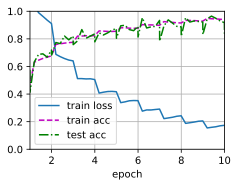

In [13]:
train_with_data_aug(train_augs, test_augs, net)
#loss 0.174,train acc 0.940640.941, test acc0.822
#loss 2064.244026096134[device(type='cuda', index=0)]

In [14]:
#rain_with_data_aug(test_augs, test_augs, net)
#loss 0.071,train acc 0.975120.975, test acc0.804
#loss 2051.566961706331[device(type='cuda', index=0)